In [1]:
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision.transforms import ToTensor, Lambda
from torchvision import datasets
from torchvision import datasets, transforms
import torch
import copy

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from torchvision.transforms import ToTensor
from torchvision import datasets

# Update the path to where you've manually placed the EMNIST dataset
data = "C:\\Users\\halil\\Documents\\GitHub\\handwritten-letter-recognition-model\\data"  # Change this to the actual path

train_data = datasets.EMNIST(
    root=data,
    split="letters",
    train=True,
    transform=ToTensor(),
    download=False,  # Set to False since you already downloaded it
)

test_data = datasets.EMNIST(
    root=data,
    split="letters",
    train=False,
    transform=ToTensor(),
    download=False,  # Set to False since you already downloaded it
)


In [4]:
len(train_data)+len(test_data)

145600

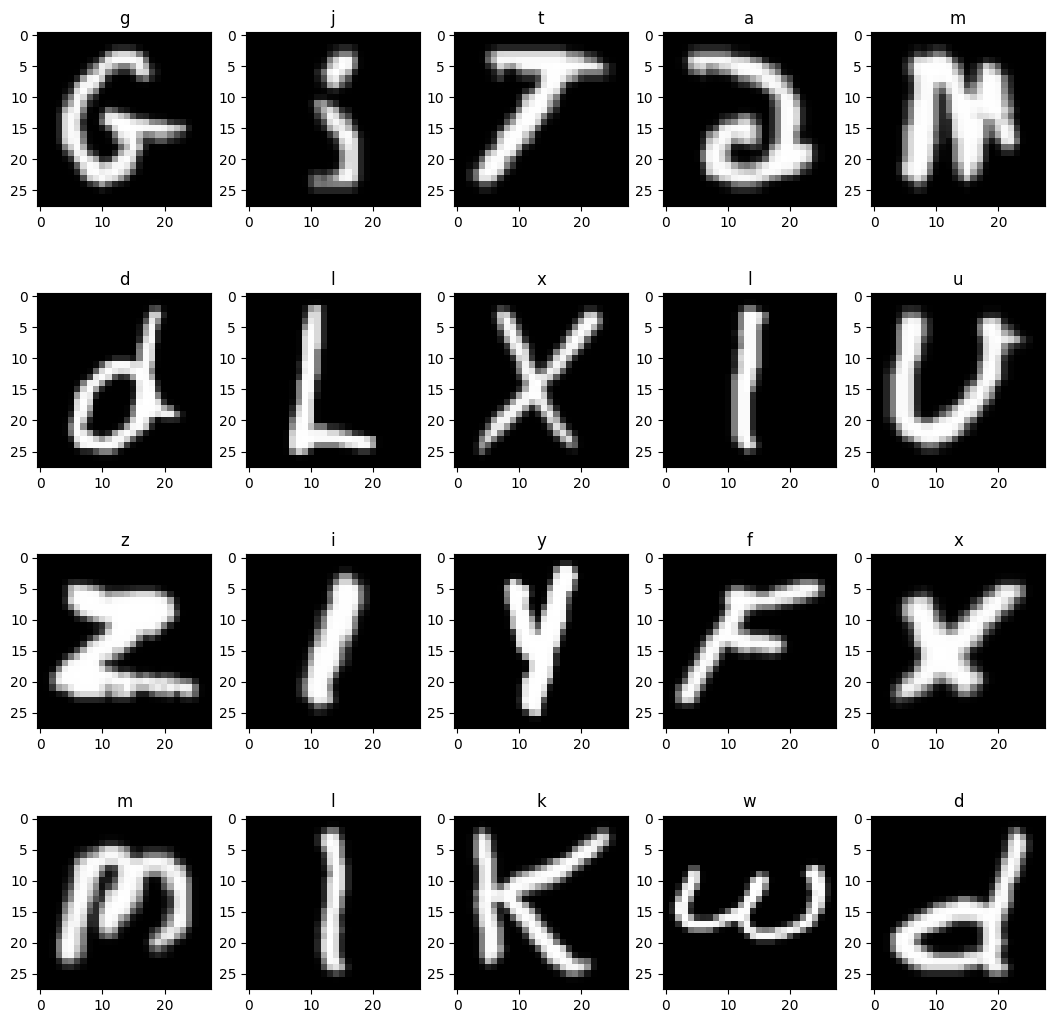

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt

image_list, label_list= [], []
for i in range(20):
  number = random.randint(0,len(train_data))
  image, label = train_data[number]
  image_list.append(image)
  label_list.append(label)

fig, axs = plt.subplots(4, 5, figsize=(13, 13))  # Create a subplot with 4 rows and 5 columns
for i, img in enumerate(image_list):  # Loop over the augmented images
    ax = axs[i // 5, i % 5]  # Determine the row and column number for each subplot
    label_name = [k for k, v in train_data.class_to_idx.items() if v == label_list[i]][0]  # Get the class name
    ax.set_title(label_name)  # Set the title for the current subplot
    ax.imshow(np.array(img).squeeze().T, cmap='gray')  # Plot the image  
plt.show()

In [51]:
train_data.classes, len(train_data.classes)

(['N/A',
  'a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'q',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'x',
  'y',
  'z'],
 27)

In [52]:
train_data.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [53]:
letterCategories = train_data.classes[1:]

labels = copy.deepcopy(train_data.targets)-1 

print(torch.sum(labels==0))

torch.unique(labels)

tensor(4800)


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

In [54]:
BATCH_SIZE = 32


train_dataloader = DataLoader(train_data, #Dataset to iterate on for the according batch size.
                              batch_size = BATCH_SIZE, #Size of every single iteration.
                              shuffle = True, #To make the loaded data selected randomly.
                              )
test_dataloader = DataLoader(test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = True)

print(f"For training data there is {len(train_dataloader)} iterations with the batch size of {BATCH_SIZE}.")
print(f"For testing data there is {len(test_dataloader)} iterations with the batch size of {BATCH_SIZE}.")

For training data there is 3900 iterations with the batch size of 32.
For testing data there is 650 iterations with the batch size of 32.


In [65]:
import torch
from torch import nn
import torch.nn.functional as F

class LetterRecognizerModel2(nn.Module):
    def __init__(self, input_size, output_size):
        super(LetterRecognizerModel2, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_size, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.55),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.55),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.55)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128*3*3, 512),
            #nn.BatchNorm4d(512),
            nn.Dropout(0.25),
            
            nn.Linear(512, 256),
            #nn.BatchNorm4d(256),
            nn.Dropout(0.55),
            
            nn.Linear(256, output_size)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc_layers(x)
        return x

torch.manual_seed(42)

model_4 = LetterRecognizerModel2(input_size=1, output_size=len(train_data.classes)).to(device)

model_4


LetterRecognizerModel2(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.55, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout(p=0.55, inplace=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1)

In [66]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                             lr=0.001)

In [67]:
def accuracy_func(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [68]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time
# Imported from learnpytorch.io directly...

In [69]:
def train_part(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_func,
               device: torch.device = device):
  train_loss, train_acc = 0 , 0
  model.to(device)

  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device) , y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_func(y_true=y,
                               y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss is:{train_loss:.5f}, Train accuracy is:{train_acc:.2f}%")
  return train_loss, train_acc

def test_part(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_func,
               device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:

      X, y = X.to(device), y.to(device)

      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_func(y_true=y,
                                y_pred = test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test loss is:{test_loss:.6f}, Test accuracy is:{test_acc:.6f}%")
  return test_loss, test_acc

In [70]:
from tqdm.auto import tqdm

torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_model_3 = timer()

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Train and test model
epochs = 50
for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_part(data_loader=train_dataloader,
        model=model_4,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_func=accuracy_func,
        device=device)
    test_loss, test_acc = test_part(data_loader=test_dataloader,
        model=model_4,
        loss_fn=loss_fn,
        optimizer = optimizer,
        accuracy_func=accuracy_func,
        device=device)
    train_losses.append(train_loss.detach().cpu().numpy())
    train_accuracies.append(train_acc)
    test_losses.append(test_loss.detach().cpu().numpy())
    test_accuracies.append(test_acc)


    print(f"Epoch: {epoch}\n---------")

train_time_end_model_3 = timer()
total_train_time_model_3 = print_train_time(start=train_time_start_model_3,
                                           end=train_time_end_model_3,
                                           device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Train loss is:2.08152, Train accuracy is:38.02%
Test loss is:0.834913, Test accuracy is:75.552885%
Epoch: 0
---------
Train loss is:0.43139, Train accuracy is:86.01%
Test loss is:0.310548, Test accuracy is:89.894231%
Epoch: 1
---------
Train loss is:0.27251, Train accuracy is:91.10%
Test loss is:0.250842, Test accuracy is:91.831731%
Epoch: 2
---------
Train loss is:0.22626, Train accuracy is:92.56%
Test loss is:0.225933, Test accuracy is:92.620192%
Epoch: 3
---------
Train loss is:0.20161, Train accuracy is:93.25%
Test loss is:0.214642, Test accuracy is:92.918269%
Epoch: 4
---------
Train loss is:0.18373, Train accuracy is:93.84%
Test loss is:0.208333, Test accuracy is:93.211538%
Epoch: 5
---------
Train loss is:0.17062, Train accuracy is:94.23%
Test loss is:0.197314, Test accuracy is:93.500000%
Epoch: 6
---------
Train loss is:0.15977, Train accuracy is:94.58%
Test loss is:0.189234, Test accuracy is:93.576923%
Epoch: 7
---------
Train loss is:0.15076, Train accuracy is:94.82%
Test los

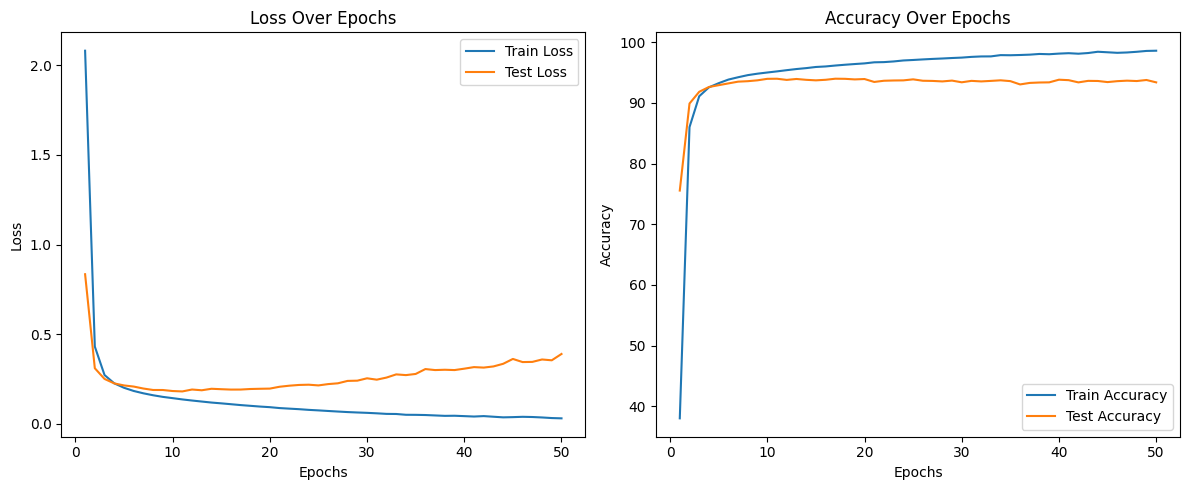

In [71]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()